# Sentiment Analysis with sklearn Classifiers & Keras LSTM

### 2 different datasets: 
- Objectivity-Subjectivity [Subjectivity dataset v1.0 from Movie Review Data](https://www.cs.cornell.edu/people/pabo/movie-review-data/)
- Polarity (Negative-Neutral-Positive) [Twitter Sentiment Analysis Dataset ver 2](https://www.kaggle.com/datasets/jp797498e/twitter-entity-sentiment-analysis)


In details I worked on this dataset in my [Machine Learning ZoomCamp](https://github.com/DataTalksClub/machine-learning-zoomcamp)'24 project in [this repo](https://github.com/dmytrovoytko/ml-sentiment-analysis-lstm/)

- this notebook provides extra analysis of correlation of subjectivity and polarity

In [75]:
import numpy as np
import pandas as pd
pd.set_option('max_colwidth', 100)
import warnings # supress warnings
warnings.filterwarnings('ignore')

DATA_DIR = f'./data/'  # ! with '/' at the end!
MODEL_DIR = f'./model/'  # ! with '/' at the end!

TEXT_COLUMN = "text"  # texts column, should be lowercased, space -> '_'
TARGET = "sentiment"  # labels column, should be lowercased, space -> '_'

DEBUG = True

## EDA and Training models on Objectivity-Subjectivity dataset

In [2]:
# these 2 CSV files contain prepared and splitted data (train/test 80/20)

DATA_FILE_NAME = 'subjectivity_train.csv'
TEST_FILE_NAME = 'subjectivity_test.csv'
ENCODING = "UTF-8"
CLASSES_NUM = 2

In [3]:
def load_dataset(file_name, encoding=ENCODING, verbose=DEBUG):
    try:
        data = pd.read_csv(DATA_DIR + file_name, encoding=encoding)
    except Exception as e:
        print('!! Failed to read_csv', DATA_DIR + file_name, e)
        data = pd.read_csv(DATA_DIR + file_name, sep=';', encoding='utf-8')

    if verbose:
        print(f' Loaded {file_name}: {data.shape[0]} records.')
        data.info()
    
    return data


In [4]:
df = load_dataset(DATA_FILE_NAME)

df

 Loaded subjectivity_train.csv: 8016 records.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8016 entries, 0 to 8015
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       8012 non-null   object
 1   sentiment  8016 non-null   object
dtypes: object(2)
memory usage: 125.4+ KB


,text,sentiment
0,the movie begins in the past where a young boy named sam attempts to save celebi from a hunter .,Objective
1,"smart and alert , thirteen conversations about one thing is a small gem .",Subjective
2,"emerging from the human psyche and showing characteristics of abstract expressionism , minimalis...",Objective
3,"color , musical bounce and warm seas lapping on island shores . and just enough science to send ...",Subjective
4,"spurning her mother's insistence that she get on with her life , mary is thrown out of the house...",Objective
...,...,...
8011,"ultimately the project comes across as clinical , detached , uninvolving , possibly prompting au...",Subjective
8012,less about shakespeare than the spawn of fools who saw quentin tarantino's handful of raucous ga...,Subjective
8013,the fact is that the screen is most alive when it seems most likely that broomfield's interviewe...,Subjective
8014,"it's difficult to imagine that a more confused , less interesting and more sloppily made film co...",Subjective


<Axes: xlabel='sentiment', ylabel='count'>

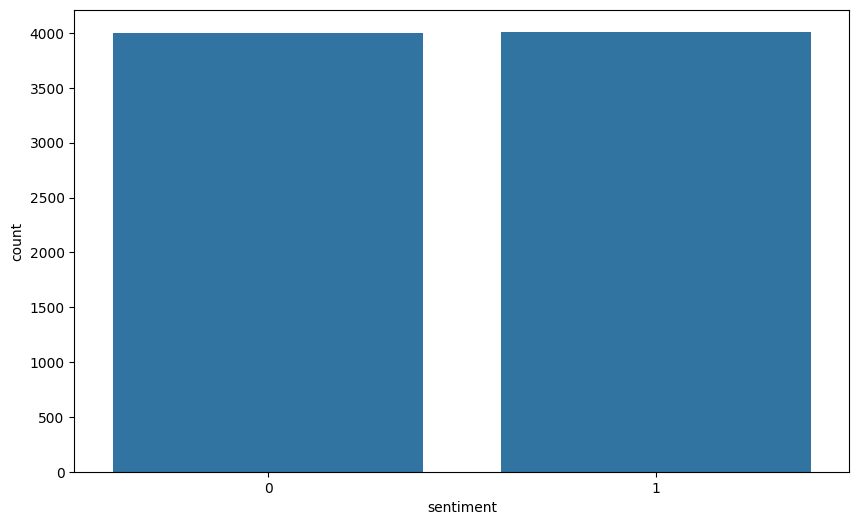

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax1 = plt.subplots(figsize=(10, 6))
sns.countplot(x='sentiment', data=df.sort_values(by=[TARGET], ascending=True), ax=ax1)

In [5]:
df[TARGET].value_counts()

sentiment
Subjective    4016
Objective     4000
Name: count, dtype: int64

In [8]:
# Let's encode sentiments
df.loc[df[TARGET] == 'Objective', TARGET] = 0
df.loc[df[TARGET] == 'Subjective', TARGET] = 1

df = df[df[TARGET].isin([0, 1, 2])] # dropping the rest
df[TARGET].value_counts()

sentiment
1    4016
0    4000
Name: count, dtype: int64

In [37]:
# Basic cleaning - remove nulls and duplicates
def clean_df(df):
    df = df[~df[TEXT_COLUMN].isnull()]
    df = df.drop_duplicates()
    return df

df = clean_df(df)

### Let's preprocess text by decontracting, removing numbers, urls, punctuation, etc

In [44]:
import re
REGX_RT = r"RT @[A-Za-z0-9$-_@.&+]+:"
REGX_USERNAME = r"@[A-Za-z0-9$-_@.&+]+"
REGX_URL = r"https?://[A-Za-z0-9./]+"
REGX_ASCII = r"[^\x00-\x7F]"

def decontract(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"let\'s", "let us", phrase)
    phrase = re.sub(r"t\'s", "t is", phrase) # it's that's
    phrase = re.sub(r"t\`s", "t is", phrase) # it's that's
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    phrase = re.sub(r"\`m", " am", phrase)

    phrase = re.sub(r"1st", "first", phrase)
    phrase = re.sub(r"2nd", "second", phrase)
    phrase = re.sub(r"3rd", "third", phrase)

    return phrase

def preprocess_text(text):
    text = re.sub(REGX_RT, ' ', text)

    text = text.lower()

    # extra html line breaks, tags
    text = re.sub('<unk>', ' ', text)
    # text = re.sub('<br />', ' ', text)
    text = re.sub('\n', ' ', text)

    text = decontract(text)

    # for twitter 
    text = re.sub(REGX_USERNAME, ' ', text)
    text = re.sub(REGX_URL, ' ', text)
    text = re.sub(REGX_ASCII, ' ', text)
    text = re.sub('dlvr.it', ' ', text)
    text = re.sub('pic.twitter.com', ' ', text)
    text = re.sub('t.co', ' ', text)
    text = re.sub('youtube.com', ' ', text)
    text = re.sub('twitch.tv', ' ', text)
    text = re.sub('instagram.com', ' ', text)
    text = re.sub('google.com', ' ', text)
    text = re.sub('https:', ' ', text)

    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'[,.:~_%<>\[\]\(\)\"|\s\-\s|\-\-]', ' ', text)  # Remove punctuation
    text = re.sub(r'\$\s', ' ', text)  # non ticker $
    text = re.sub(r'\s\$$', ' ', text)  # trailing $
    text = re.sub(' +', ' ', text) # multiple spaces
    text = re.sub(r'^\s+', '', text) # leading spaces
    text = re.sub(r'\s+$', '', text) # trailing spaces
    return text

In [42]:
# Apply preprocessing
df[TEXT_COLUMN] = df[TEXT_COLUMN].apply(preprocess_text)
df.head(10)

,text,sentiment,text_len
0,the movie begins in the past where a young boy named sam attempts to save celebi from a hunter,0,96.0
1,smart and alert thirteen conversations about one thing is a small gem,1,73.0
2,emerging from the human psyche and showing characteristics of abstract expressionism minimalism ...,0,278.0
3,color musical bounce and warm seas lapping on island shores and just enough science to send you ...,1,115.0
4,spurning her mother's insistence that she get on with her life mary is thrown out of the house r...,0,174.0
5,it is not a mass market entertainment but an uncompromising attempt by one artist to think about...,1,106.0
6,amitabh can not believe the board of directors and his mind is filled with revenge and what bett...,0,161.0
7,a light hearted french film about the spiritual quest of a fashion model seeking peace of mind w...,1,167.0
8,she among others excentricities talks to a small rock gertrude like if she was alive,0,94.0
9,my wife is an actress has its moments in looking at the comic effects of jealousy in the end tho...,1,170.0


In [43]:
# Let's see text length variation
df['text_len'] = df[TEXT_COLUMN].str.len()
df['text_len'].describe()

count    8012.000000
mean      122.062282
std        51.349675
min        18.000000
25%        84.000000
50%       114.000000
75%       152.000000
max       459.000000
Name: text_len, dtype: float64

In [46]:
# Let's drop extra short rows
MIN_LENGTH = 10
df = df[df[TEXT_COLUMN].str.len()>=MIN_LENGTH] 
df.shape[0]

8012

In [47]:
df[TARGET] = df[TARGET].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8012 entries, 0 to 8015
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       8012 non-null   object
 1   sentiment  8012 non-null   int64 
 2   text_len   8012 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 250.4+ KB


### Let's see most frequent words for the whole dataset, Objective, Subjective

In [48]:
from wordcloud import WordCloud,STOPWORDS
def df_wordcloud(df):
  words = ' '.join(df[TEXT_COLUMN])
  wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=4000,
                      height=2500
                     ).generate(words)
  plt.figure(1,figsize=(12, 15))
  plt.imshow(wordcloud)
  plt.axis('off')
  plt.show()

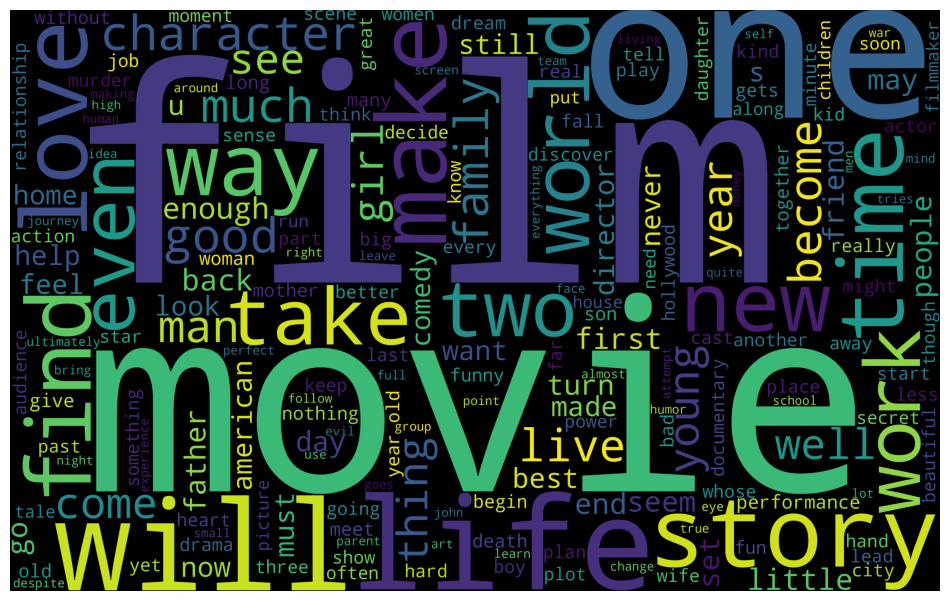

In [51]:
df_wordcloud(df) # all

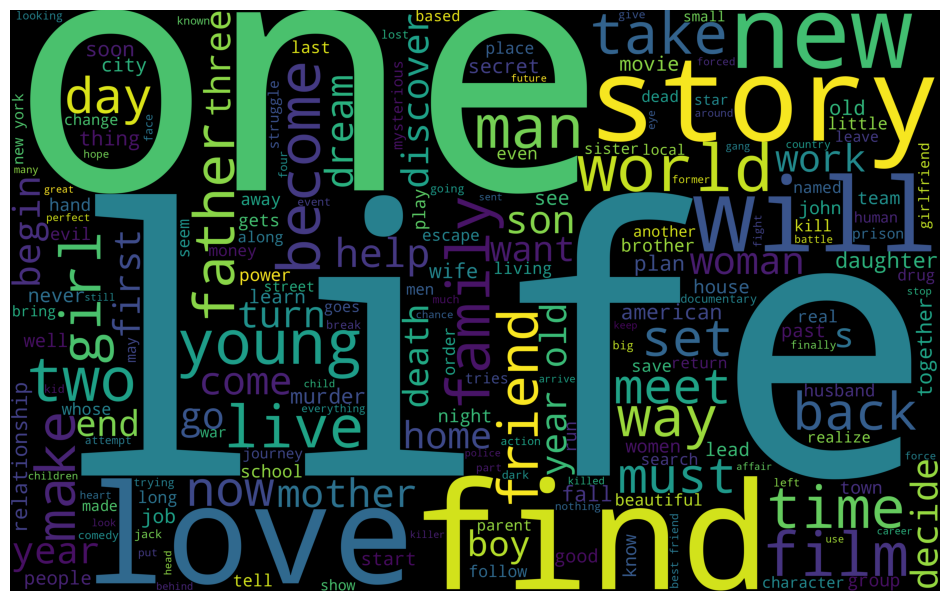

In [54]:
df_wordcloud(df[df[TARGET]==0]) # Objective

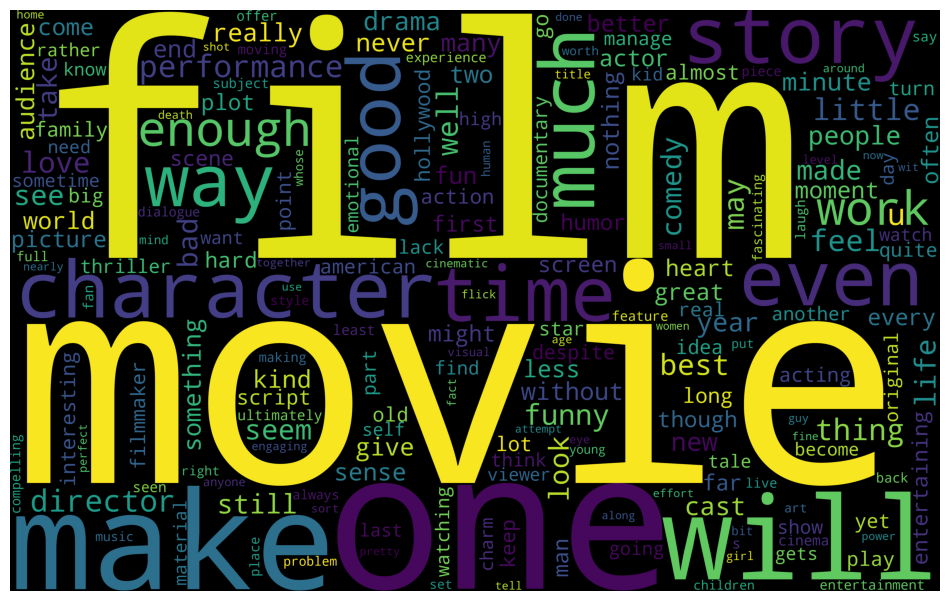

In [55]:
df_wordcloud(df[df[TARGET]==1]) # Subjective

In [53]:
# let's look at TOP50 frequent words
# we don't remove stop words to keep sentiment information
freq = pd.Series(' '.join(df[TEXT_COLUMN]).split()).value_counts()[:50]
freq

the      9343
a        6299
and      5451
of       5110
to       4427
is       3600
in       2855
it       1822
that     1732
his      1596
with     1512
as       1382
for      1325
not      1053
an       1051
on       1042
but      1011
he        936
her       914
this      866
by        816
who       755
are       742
film      735
has       731
be        680
from      676
its       627
their     618
at        597
one       595
movie     575
you       547
they      541
when      508
about     502
out       481
all       476
have      475
more      445
up        428
life      418
she       417
will      411
into      405
story     398
him       352
can       346
like      342
than      342
Name: count, dtype: int64

## Let's prepare data for training

### Keras LSTM first

In [56]:
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import classification_report, multilabel_confusion_matrix, ConfusionMatrixDisplay

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
labelencoder = LabelEncoder()
onehotencoder = OneHotEncoder()
ordinalencoder = OrdinalEncoder()

y = df[TARGET].values
y_label = labelencoder.fit_transform(y)
print(y_label[-10:])
y_ohe = onehotencoder.fit_transform(y_label.reshape(-1, 1)).toarray()
print(y_ohe[-10:])

[1 1 1 1 1 1 1 1 1 1]
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [58]:
# Train/Val/Test

val_size = 0.15
test_size = 0.15

df_train  = df[0:int(df.shape[0]*(1-val_size-test_size))]
y_train  = y_ohe[0:int(df.shape[0]*(1-val_size-test_size))]

print('Train:', df_train.shape, y_train.shape)

df_val  = df[df_train.shape[0]:int(df.shape[0]*(1-test_size))]
df_val.reset_index(inplace = True, drop = True)

y_val  = y_ohe[df_train.shape[0]:int(df.shape[0]*(1-test_size))]
print('Val:', df_val.shape, y_val.shape)

df_test  = df[int(df.shape[0]*(1-test_size)):]
df_test.reset_index(inplace = True, drop = True)

y_test  = y_ohe[int(df.shape[0]*(1-test_size)):]
print('Test:', df_test.shape, y_test.shape)


Train: (5608, 3) (5608, 2)
Val: (1202, 3) (1202, 2)
Test: (1202, 3) (1202, 2)


In [59]:
X_train_final_text = df_train[TEXT_COLUMN].values
X_val_final_text = df_val[TEXT_COLUMN].values
X_test_final_text = df_test[TEXT_COLUMN].values

In [62]:
#total unique word count in whole corpus
total_unique_words = len(set((' ').join(df[TEXT_COLUMN].values).split()))
total_unique_words

19824

In [63]:
#total unique word cound in train corpus
len(set((' ').join(df_train[TEXT_COLUMN].values).split()))

16564

In [64]:
df['totalwords_after_cleaning'] = df[TEXT_COLUMN].str.split().str.len()
df['totalwords_after_cleaning'].describe()

count    8012.000000
mean       21.710434
std         9.042116
min         3.000000
25%        15.000000
50%        20.000000
75%        27.000000
max        79.000000
Name: totalwords_after_cleaning, dtype: float64

<Axes: >

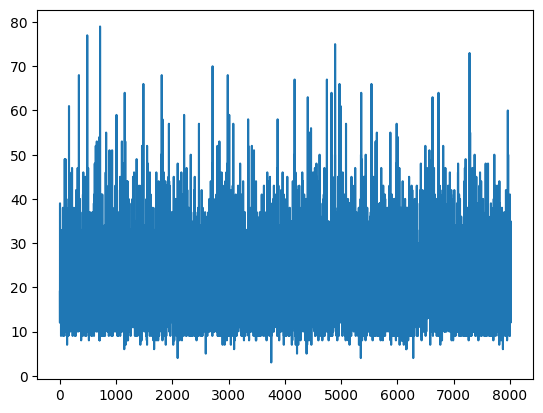

In [65]:
df['totalwords_after_cleaning'].plot()

In [66]:
# max training and test sequence length
MAX_LEN = 80

In [85]:
# from numpy import array
# from numpy import asarray
# from numpy import zeros
# import tensorflow as tf
# # from keras.preprocessing.text import Tokenizer
# from tensorflow.keras.preprocessing.text import Tokenizer

# # from keras.preprocessing.sequence import pad_sequences
# from tensorflow.keras.preprocessing.sequence import pad_sequences
# from keras.models import Sequential
# from keras.layers import Dense
# from keras.layers import Flatten
# from keras.layers import Embedding

# num_words = total_unique_words
# oov_token = '<UNK>'
# pad_type = 'post'
# trunc_type = 'post'

# # Tokenize our training data
# tokenizer = Tokenizer(num_words=num_words, oov_token=oov_token, filters='!"#$%&()*+,-/:;<=>?@[\\]^`{|}~\t\n') #not filtering "_"
# tokenizer.fit_on_texts(X_train_final_text)

# # Get our training  data word index
# word_index = tokenizer.word_index

# vocab_size = len(tokenizer.word_index) + 1
# print('vocab_size', vocab_size)

# # Encode training and test data sentences into sequences
# train_sequences = tokenizer.texts_to_sequences(X_train_final_text)
# val_sequences = tokenizer.texts_to_sequences(X_val_final_text)
# test_sequences = tokenizer.texts_to_sequences(X_test_final_text)


# # Pad the training  and test sequences
# train_padded = pad_sequences(train_sequences, padding=pad_type, truncating=trunc_type, maxlen=MAX_LEN)
# val_padded = pad_sequences(val_sequences, padding=pad_type, truncating=trunc_type, maxlen=MAX_LEN)
# test_padded = pad_sequences(test_sequences, padding=pad_type, truncating=trunc_type, maxlen=MAX_LEN)

# # Output the results of our work
# #print("Word index:\n", word_index)
# #print("\nTraining sequences:\n", train_sequences)
# #print("\nPadded training sequences:\n", train_padded)
# print("\nPadded training shape:", train_padded.shape)
# print("Training sequences data type:", type(train_sequences))
# print("Padded Training sequences data type:", type(train_padded))
# print("\nPadded validation shape:", val_padded.shape)
# print("validation sequences data type:", type(val_sequences))
# print("Padded validation sequences data type:", type(val_padded))
# print("\nPadded test shape:", test_padded.shape)
# print("test sequences data type:", type(test_sequences))
# print("Padded test sequences data type:", type(test_padded))

In [86]:

# import tensorflow as tf

# val_features_list = [val_padded]

# class Metrics(tf.keras.callbacks.Callback):

#     def on_train_begin(self, logs={}):
#         self.val_f1s = []
#         self.val_recalls = []
#         self.val_precisions = []

#     def on_epoch_end(self, epoch, logs={}):
#         val_predict = (np.asarray(self.model.predict(val_features_list))).round()
#         val_targ = y_val
#         _val_f1 = f1_score(val_targ, val_predict, average='micro')
#         _val_recall = recall_score(val_targ, val_predict, average='micro')
#         _val_precision = precision_score(val_targ, val_predict, average='micro')
#         self.val_f1s.append(_val_f1)
#         self.val_recalls.append(_val_recall)
#         self.val_precisions.append(_val_precision)
#         print (" — val_f1: %f — val_precision: %f — val_recall %f" %(_val_f1, _val_precision, _val_recall))

#         return


# metrics = Metrics()

In [87]:
# from tensorflow.keras.layers import Activation, Conv2D, Input, Embedding, Bidirectional, Reshape, MaxPool2D, Concatenate, Flatten, Dropout, Dense, Conv1D, MaxPool1D
# from tensorflow.keras.models import Model
# from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler, EarlyStopping, TerminateOnNaN, TensorBoard
# from tensorflow.keras.optimizers import Adam
# import datetime, os
# from tensorflow.keras.layers import LSTM


# drop = 0.4


# ##########################
# ### text input
# input1 = Input(shape=(MAX_LEN,), name = 'text')
# #print(input1.shape)
# embedding_layer1 = Embedding(vocab_size, 128) #, weights=[embedding_matrix], input_length=120, trainable=False)
# embedding1 = embedding_layer1(input1)
# # lstm1 = LSTM(100, dropout=drop, recurrent_dropout=drop)(embedding1)
# lstm1 = Bidirectional(LSTM(64, return_sequences=True, dropout=drop, recurrent_dropout=0.7))(embedding1)
# lstm2 = Bidirectional(LSTM(64, dropout=drop, recurrent_dropout=drop))(lstm1)

# # dense1 = Dense(24, activation='relu')(lstm2)

# output = Dense(units=2, activation='softmax')(lstm2) # (lstm2) #dense1 (dropout1)

# earlystop = EarlyStopping(monitor='val_accuracy', min_delta=0.01, patience=1, verbose=1,
#     mode="max") #"auto")
# filepath="model_save/weights-{epoch:02d}-{val_accuracy:.4f}.keras"
# logdir = os.path.join("logss", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
# tensorboard_callback = TensorBoard(log_dir=logdir,histogram_freq=1, write_graph=True) #,write_grads=True)
# metrics = Metrics()

# checkpoint = ModelCheckpoint('weights_lstm.keras', monitor='val_accuracy',
#                              verbose=1, save_best_only=True, mode='auto')

# callback_list = [earlystop,checkpoint, tensorboard_callback, metrics]


# model = Model(inputs=[input1], outputs=output)

# adam = Adam(
#     learning_rate=0.001,
#     # beta_1=0.9,
#     # beta_2=0.999,
#     # epsilon=1e-07,
# )

# model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
# model.summary()


In [88]:
# from tensorflow.keras.utils import plot_model
# plot_model(model, show_shapes=True)

In [89]:
# !rm -rf logss/

In [90]:
# print(list(y_train[:5]))
# print(list(y_val[:5]))
# np.argmax(y_train[:5], axis=1)

In [91]:
# df_train[target].value_counts()

In [92]:
# df_val[target].value_counts()

In [93]:
# train_features = {"text" : train_padded}
# val_features = {"text" : val_padded}

# model_history = model.fit(train_features, y_train,
#                           batch_size=32, epochs=50,
#                           validation_data = (val_features, y_val),
#                           callbacks=[callback_list])


In [94]:
# Load the TensorBoard notebook extension
# %load_ext tensorboard
# %reload_ext tensorboard

In [95]:
# !kill 8376

In [96]:
# %tensorboard --logdir logss/

In [97]:
# test_features = {"text" : test_padded}
# test_scores = model.evaluate(test_features, y_test, verbose=2)

In [98]:
# test_features_list = [test_padded]


# test_predict = (np.asarray(model.predict(test_features_list))).round()
# test_targ = y_test
# _test_f1 = f1_score(test_targ, test_predict, average='macro') # , average='micro'
# _test_recall = recall_score(test_targ, test_predict, average='macro') # , average='micro'
# _test_precision = precision_score(test_targ, test_predict, average='macro') # , average='micro'

# print(f"test\n — test_f1: {_test_f1}\n — test_precision: {_test_precision}\n — test_recall {_test_recall}")

In [99]:

# # Creating  a confusion matrix,which compares the y_test and y_pred
# cr = classification_report(y_test, test_predict, digits=3, zero_division=0)
# print(cr)
# multilabel_confusion_matrix(y_test, test_predict)

In [100]:
# from sklearn.metrics import roc_curve, roc_auc_score
# roc_auc_score(y_test, test_predict, multi_class='ovr')

In [101]:
# import matplotlib.pyplot as plt
# def plot_history(history):
#   plt.figure(figsize=(12, 5))

#   # (accuracy)
#   plt.subplot(1, 2, 2)
#   plt.plot(history.history['accuracy'], label='Train Accuracy')
#   plt.plot(history.history['val_accuracy'], label='Val Accuracy')
#   plt.title('(Accuracy) Curves')
#   plt.xlabel('Epoch')
#   plt.ylabel('(Accuracy)')
#   plt.legend()

#   # (loss)
#   plt.subplot(1, 2, 1)
#   plt.plot(history.history['loss'], label='Train Loss')
#   plt.plot(history.history['val_loss'], label='Val Loss')
#   plt.title('(Loss) Curves')
#   plt.xlabel('Epoch')
#   plt.ylabel('(Loss)')
#   plt.legend()

#   plt.tight_layout()
#   plt.show()

In [102]:
# plot_history(model_history)

## Let's check performance of sklearn ML models

In [67]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

# Define the feature (X) and target (y) columns
X = df[TEXT_COLUMN]
y = df[TARGET]

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

# Vectorize the text data
vectorizer = TfidfVectorizer(norm='l2', sublinear_tf=True) # max_features=vocab_size 
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

### LogisticRegression

In [68]:
# Train LogisticRegression model
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression()
lr_model.fit(X_train_vectorized, y_train)

# Make predictions and evaluate the model
y_pred = lr_model.predict(X_test_vectorized)
print("LogisticRegression Model Performance")
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

LogisticRegression Model Performance
Accuracy: 0.8976918278228322
              precision    recall  f1-score   support

           0       0.90      0.89      0.90       786
           1       0.90      0.90      0.90       817

    accuracy                           0.90      1603
   macro avg       0.90      0.90      0.90      1603
weighted avg       0.90      0.90      0.90      1603



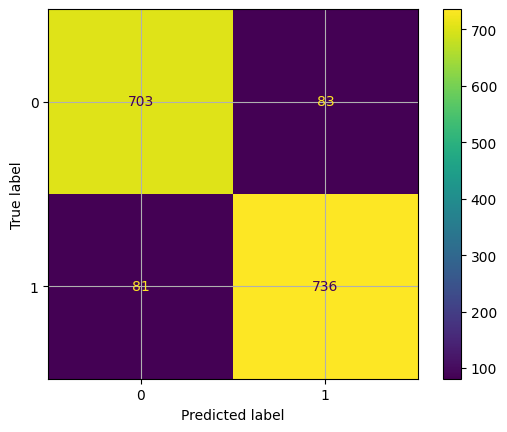

In [69]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.grid(None);

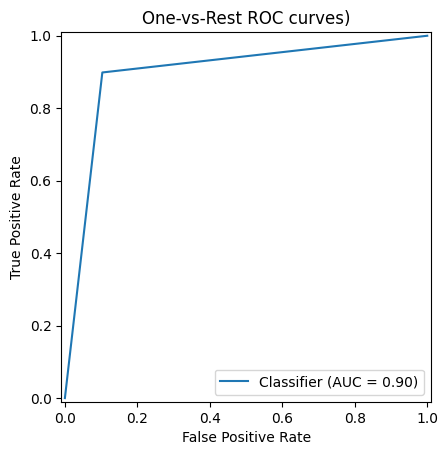

In [70]:
from sklearn.metrics import RocCurveDisplay

display = RocCurveDisplay.from_predictions(y_pred, y_test,)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="One-vs-Rest ROC curves)",
)

In [73]:
def text_predict(text, model, vectorizer):
  test_text_vectorized = vectorizer.transform([text])
  test_text_pred = model.predict(test_text_vectorized)
  print(text, '->', int(test_text_pred))


In [76]:
# 0 - objective, 1 - subjective

text_predict("I love this funny movie!", lr_model, vectorizer)
text_predict("I hate that boring movie!", lr_model, vectorizer)

# objective, from subjectivity_test.csv
text_predict("dre is an executive with a hip-hop record company based in new york", lr_model, vectorizer)
text_predict("to define family guy must seek beyond what he can see touch taste smell or hear", lr_model, vectorizer)

# subjective, from subjectivity_test.csv
text_predict("resident evil may be brain dead but it's great popcorn entertainment nonetheless", lr_model, vectorizer)

I love this funny movie! -> 1
I hate that boring movie! -> 1
dre is an executive with a hip-hop record company based in new york -> 0
to define family guy must seek beyond what he can see touch taste smell or hear -> 0
resident evil may be brain dead but it's great popcorn entertainment nonetheless -> 1


### MultinomialNB

In [77]:
# Train Naive Bayes model
nb_model = MultinomialNB()
history = nb_model.fit(X_train_vectorized, y_train)

# Make predictions and evaluate the model
y_pred = nb_model.predict(X_test_vectorized)
print("Naive Bayes Model Performance")
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Naive Bayes Model Performance
Accuracy: 0.9232688708671242
              precision    recall  f1-score   support

           0       0.93      0.91      0.92       786
           1       0.92      0.94      0.93       817

    accuracy                           0.92      1603
   macro avg       0.92      0.92      0.92      1603
weighted avg       0.92      0.92      0.92      1603



In [ ]:
# 0 - objective, 1 - subjective

text_predict("I love this funny movie!", nb_model, vectorizer)
text_predict("I hate that boring movie!", nb_model, vectorizer)

# objective, from subjectivity_test.csv
text_predict("dre is an executive with a hip-hop record company based in new york", nb_model, vectorizer)
text_predict("to define family guy must seek beyond what he can see touch taste smell or hear", nb_model, vectorizer)

# subjective, from subjectivity_test.csv
text_predict("resident evil may be brain dead but it's great popcorn entertainment nonetheless", nb_model, vectorizer)

I love this funny movie! -> 1
I hate that boring movie! -> 1
dre is an executive with a hip-hop record company based in new york -> 0
to define family guy must seek beyond what he can see touch taste smell or hear -> 0
resident evil may be brain dead but it's great popcorn entertainment nonetheless -> 1


### DecisionTreeClassifier

In [79]:
# Train DecisionTreeClassifier model
from sklearn.tree import DecisionTreeClassifier
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train_vectorized, y_train)

# Make predictions and evaluate the model
y_pred = dt_model.predict(X_test_vectorized)
print("DecisionTreeClassifier Model Performance")
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

DecisionTreeClassifier Model Performance
Accuracy: 0.7479725514660013
              precision    recall  f1-score   support

           0       0.73      0.78      0.75       786
           1       0.77      0.72      0.74       817

    accuracy                           0.75      1603
   macro avg       0.75      0.75      0.75      1603
weighted avg       0.75      0.75      0.75      1603



In [ ]:
# 0 - objective, 1 - subjective

text_predict("I love this funny movie!", dt_model, vectorizer)
text_predict("I hate that boring movie!", dt_model, vectorizer)

# objective, from subjectivity_test.csv
text_predict("dre is an executive with a hip-hop record company based in new york", dt_model, vectorizer)
text_predict("to define family guy must seek beyond what he can see touch taste smell or hear", dt_model, vectorizer)

# subjective, from subjectivity_test.csv
text_predict("resident evil may be brain dead but it's great popcorn entertainment nonetheless", dt_model, vectorizer)

I love this funny movie! -> 1
I hate that boring movie! -> 1
dre is an executive with a hip-hop record company based in new york -> 0
to define family guy must seek beyond what he can see touch taste smell or hear -> 0
resident evil may be brain dead but it's great popcorn entertainment nonetheless -> 1


### AdaBoostClassifier

In [81]:
# Train AdaBoostClassifier model
from sklearn.ensemble import AdaBoostClassifier
ab_model = AdaBoostClassifier()
ab_model.fit(X_train_vectorized, y_train)

# Make predictions and evaluate the model
y_pred = ab_model.predict(X_test_vectorized)
print("AdaBoostClassifier Model Performance")
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

AdaBoostClassifier Model Performance
Accuracy: 0.74235807860262
              precision    recall  f1-score   support

           0       0.69      0.85      0.76       786
           1       0.82      0.64      0.72       817

    accuracy                           0.74      1603
   macro avg       0.75      0.74      0.74      1603
weighted avg       0.76      0.74      0.74      1603



In [83]:
# 0 - objective, 1 - subjective

text_predict("I love this funny movie!", ab_model, vectorizer)
text_predict("I hate that boring movie!", ab_model, vectorizer)

# objective, from subjectivity_test.csv
text_predict("dre is an executive with a hip-hop record company based in new york", ab_model, vectorizer)
text_predict("to define family guy must seek beyond what he can see touch taste smell or hear", ab_model, vectorizer)

# subjective, from subjectivity_test.csv
text_predict("resident evil may be brain dead but it's great popcorn entertainment nonetheless", ab_model, vectorizer)

I love this funny movie! -> 1
I hate that boring movie! -> 1
dre is an executive with a hip-hop record company based in new york -> 0
to define family guy must seek beyond what he can see touch taste smell or hear -> 0
resident evil may be brain dead but it's great popcorn entertainment nonetheless -> 1


### RandomForestClassifier

In [85]:
# Train RandomForestClassifier model
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier()
rf_model.fit(X_train_vectorized, y_train)

# Make predictions and evaluate the model
y_pred = rf_model.predict(X_test_vectorized)
print("RandomForestClassifier Model Performance")
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

RandomForestClassifier Model Performance
Accuracy: 0.8658764815970056
              precision    recall  f1-score   support

           0       0.86      0.86      0.86       786
           1       0.87      0.87      0.87       817

    accuracy                           0.87      1603
   macro avg       0.87      0.87      0.87      1603
weighted avg       0.87      0.87      0.87      1603



In [86]:
# 0 - objective, 1 - subjective

text_predict("I love this funny movie!", rf_model, vectorizer)
text_predict("I hate that boring movie!", rf_model, vectorizer)

# objective, from subjectivity_test.csv
text_predict("dre is an executive with a hip-hop record company based in new york", rf_model, vectorizer)
text_predict("to define family guy must seek beyond what he can see touch taste smell or hear", rf_model, vectorizer)

# subjective, from subjectivity_test.csv
text_predict("resident evil may be brain dead but it's great popcorn entertainment nonetheless", rf_model, vectorizer)

I love this funny movie! -> 1
I hate that boring movie! -> 1
dre is an executive with a hip-hop record company based in new york -> 0
to define family guy must seek beyond what he can see touch taste smell or hear -> 0
resident evil may be brain dead but it's great popcorn entertainment nonetheless -> 1


## Classifiers performance summary

- LogisticRegression  Accuracy: 0.8976918278228322
- Naive Bayes  Accuracy: 0.9232688708671242
- DecisionTreeClassifier  Accuracy: 0.7479725514660013
- AdaBoostClassifier  Accuracy: 0.74235807860262
- RandomForestClassifier  Accuracy: 0.8658764815970056

### Leaders:
- Naive Bayes  Accuracy: 0.9232688708671242
- LogisticRegression  Accuracy: 0.8976918278228322

In [ ]:
from settings import DATA_FILE2
from preprocess import load_data
# test_file = TEST_FILE3
test_file = DATA_FILE2
df = load_data(test_file)
df.columns = df.columns.str.replace(TARGET, 'positivity')
# df[TARGET] = 0

df.head()

DATA_DIR = './data/'

df0 = pd.read_csv(f'{DATA_DIR}polarity-subjectivity2.csv') # rt-polarity_train subjectivity_train sentiment_analysis
print('Total records:', df0.shape[0])

selected_columns = ['text', 'positivity', 'subjectivity']

df = df0[selected_columns]
df.info()

print('\nWithout nulls')
df = df.dropna()
print(df.describe().T)

print(df.head())

In [ ]:

# df.loc[df[target] == 'Objective', target] = 0
# df.loc[df[target] == 'Subjective', target] = 1
df.loc[df[target] == 'negative', target] = 0
df.loc[df[target] == 'neutral', target] = 1
df.loc[df[target] == 'positive', target] = 2
df = df[df[target].isin([0, 1, 2])] # dropping the rest
df[target].value_counts()

sentiment
1    199
2    166
0    134
Name: count, dtype: int64

In [ ]:
target = 'subjectivity'
corr = df.corr(numeric_only=True)[target]
print(f'\nCorrelation to {target}:\n{corr.sort_values().to_string()}')


Correlation to subjectivity:
positivity      0.027978
subjectivity    1.000000


positivity        0     1      2
subjectivity                    
0              6529  7898   5069
1             13735  8414  12822


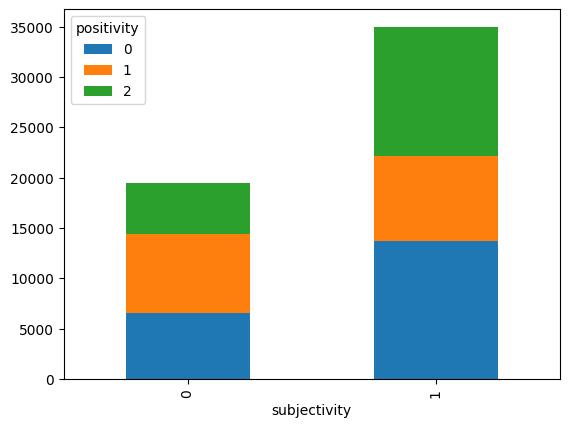

In [ ]:
df2 = df.groupby(['subjectivity', 'positivity'])['subjectivity'].count().unstack('positivity').fillna(0)
df2.plot(kind='bar', stacked=True)
print(df2)

subjectivity     0      1
positivity               
0             6529  13735
1             7898   8414
2             5069  12822


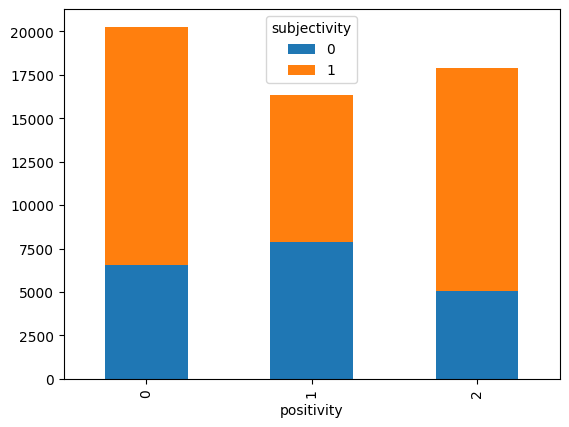

In [ ]:
df2 = df.groupby(['subjectivity', 'positivity'])['positivity'].count().unstack('subjectivity').fillna(0)
df2.plot(kind='bar', stacked=True)
print(df2)

In [ ]:
df2.index, df2.columns

(Index([0, 1, 2], dtype='int64', name='positivity'),
 Index([0, 1], dtype='int64', name='subjectivity'))

<Axes: >

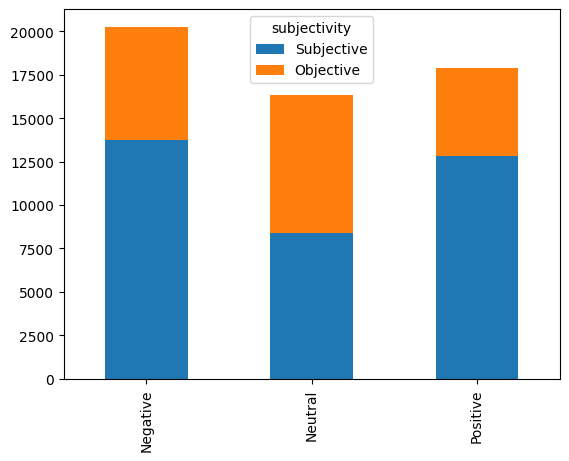

In [ ]:
df3 = df2[[1, 0]].rename(columns={1: 'Subjective', 0: 'Objective'})
df3.index = ['Negative', 'Neutral', 'Positive']
df3.plot(kind='bar', stacked=True)

<Axes: xlabel='subjectivity'>

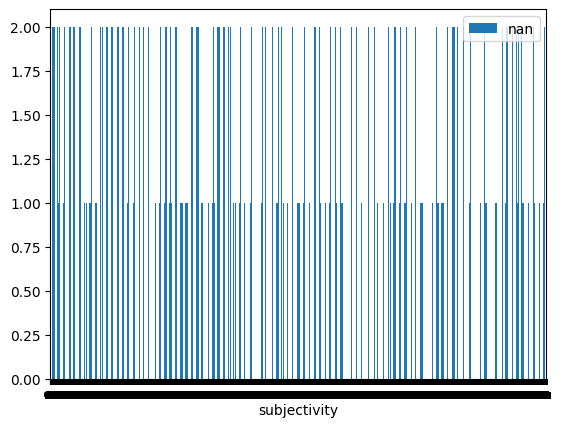

In [ ]:
#Convert subjectivity as index, so columns are the categories
df3 = df2.set_index('subjectivity') 

#Set categories... Order will 1-0
df3.columns=pd.CategoricalIndex(df2.columns.values, ordered=True, categories=[1,0])

#Sort the data
# df2 = df2.sort_index(axis=1)

#...and plot
# df2.plot.barh(stacked=True)
df3.plot(kind='bar', stacked=True)